In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# GPU設定
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# データのダウンロード

In [3]:
# ダウンロード
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
y_train.shape

(60000,)

In [6]:
# 入力画像の次元拡張
x_train = x_train[:, :, :, np.newaxis]
x_train.shape

(60000, 28, 28, 1)

In [7]:
# One-hot
(y_train, y_test) = (np_utils.to_categorical(y_train), np_utils.to_categorical(y_test))
y_train.shape

(60000, 10)

Text(0.5, 1.0, '7')

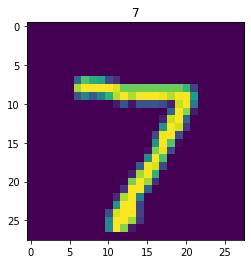

In [8]:
# テスト画像の表示
i = 0
label = y_test[i].argmax()
plt.imshow(x_test[i])
plt.title(label)

# モデル作成

In [9]:
from keras.layers import Input, ZeroPadding2D, Conv2D, GlobalAveragePooling2D, Dense, Dropout
from keras import Model

In [10]:
inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, (5, 5), strides=(2, 2), padding='same', activation='relu')(inputs)
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu', name='feature_map')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax', name='dense')(x)

In [11]:
model = Model(inputs=inputs, outputs=outputs)

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
feature_map (Conv2D)         (None, 14, 14, 128)       73856     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290

In [14]:
hist = model.fit(x_train, y_train, validation_split=0.1, epochs=5)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 8s 142us/step - loss: 0.4579 - accuracy: 0.8556 - val_loss: 0.0702 - val_accuracy: 0.9807
Epoch 2/5
54000/54000 [==============================] - 6s 118us/step - loss: 0.1266 - accuracy: 0.9619 - val_loss: 0.0496 - val_accuracy: 0.9857
Epoch 3/5
54000/54000 [==============================] - 7s 123us/step - loss: 0.0948 - accuracy: 0.9720 - val_loss: 0.0463 - val_accuracy: 0.9880
Epoch 4/5
54000/54000 [==============================] - 7s 126us/step - loss: 0.0789 - accuracy: 0.9768 - val_loss: 0.0319 - val_accuracy: 0.9918
Epoch 5/5
54000/54000 [==============================] - 7s 125us/step - loss: 0.0660 - accuracy: 0.9804 - val_loss: 0.0284 - val_accuracy: 0.9928


# 結果

Text(0.5, 1.0, 'pred=2, ans=2')

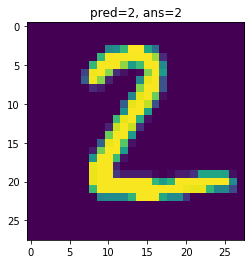

In [15]:
# テスト画像の表示
i = np.random.randint(0, 11)
pred = model.predict(x_test[i][np.newaxis, :, :, np.newaxis]).argmax()
ans = y_test[i].argmax()

plt.imshow(x_test[i])
plt.title('pred={0}, ans={1}'.format(pred, ans))

# CAM

In [16]:
from class_activation_map import ClassActivationMap

In [18]:
# ClassActivationMap計算用クラスの作成
cam = ClassActivationMap(model)

In [37]:
# CAMを計算したい画像
images = x_test[[0], :, :, np.newaxis]
labels = y_test[[0]]
images.shape

(1, 28, 28, 1)

In [38]:
# ClassActivationMapを計算
cam_images = cam.get_class_activation_map(images)
cam_images.shape

(1, 14, 14, 10)

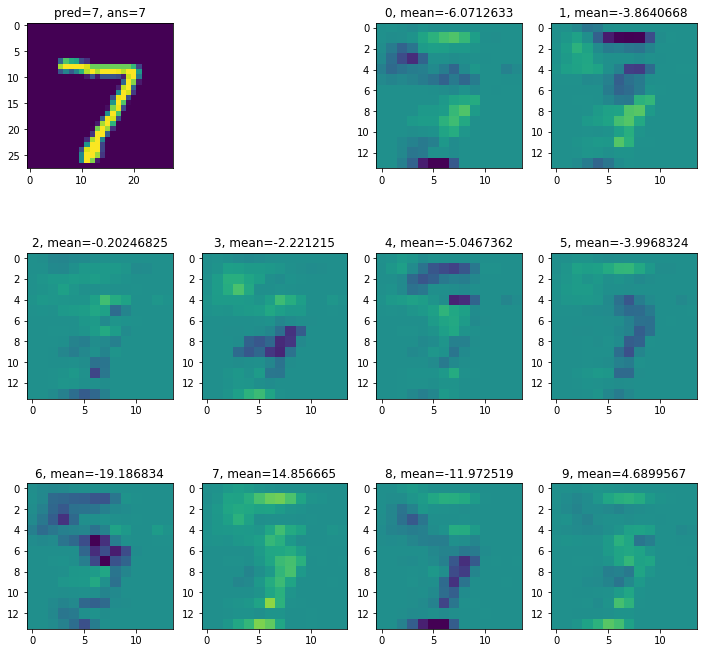

In [41]:
# 図示する画像を一枚だけ選ぶ
i = 0
image = images[i]
label = labels[i]
cam_image = cam_images[i]

# 予測結果と答えを計算
pred = model.predict(image[np.newaxis, :, :, :]).argmax()  # 予測結果
ans = answers[0].argmax()  # 答え

### 図示 ###
plt.figure(figsize=(12, 12))
# 元画像
plt.subplot(341)
plt.imshow(image[:, :, 0])
plt.title('pred={0}, ans={1}'.format(pred, ans))
# CAM
for j in range(10):
    cam_class = cam_image[:, :, j]  # あるクラスのCAMを取得
    plt.subplot(3, 4, j+3)
    plt.imshow(cam_class, vmin=-200, vmax=200)
    plt.title(str(j) + ', mean=' + str(cam_class.mean()))  # あるクラスのCAMの平均